# RQ1

Tables in database: ['vulnerabilities', 'sqlite_sequence', 'vulnerabilities_deepseek_r1_7b', 'vulnerabilities_llama3_1_8b', 'vulnerabilities_gemma2_9b', 'vulnerabilities_qwen2_5_coder_7b', 'vulnerabilities_codellama_7b', 'vulnerabilities_deepseek_r1_32b', 'vulnerabilities_deepseek_v2_16b', 'vulnerabilities_deepseek_coder_16b', 'vulnerabilities_qwen2_5_coder_32b', 'vulnerabilities_codellama_34b', 'new_vulnerabilities']
Vulnerabilities table columns: ['id', 'COMMIT_HASH', 'VULNERABILITY_CVE', 'VULNERABILITY_YEAR', 'VULNERABILITY_CWE', 'VULNERABILITY_CATEGORY', 'DESCRIPTION_IN_PATCH', 'VULNERABLE_CODE_BLOCK', 'PATCHED_CODE_BLOCK', 'NUM_FILES_CHANGED', 'NUM_FUNCTIONS_CHANGED', 'NUM_LINES_ADDED', 'NUM_LINES_DELETED', 'PROJECT', 'NUM_LINES_IN_VULNERABLE_CODE_BLOCK', 'NUM_LINES_IN_PATCHED_CODE_BLOCK', 'NOISE_AMOUNT', 'NOISE_REASONING']
Loaded 593 vulnerability records
No noise_level column found in vulnerabilities table
Found potential noise columns: ['NOISE_AMOUNT', 'NOISE_REASONING']
Found 

/tmp/ipykernel_484047/1489113206.py:128: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  decisions = pd.concat(all_models_data, ignore_index=True)


Deepseek R1 7B - Correlation: -0.018, p-value: 0.664
Llama3 1 8B - Correlation: -0.034, p-value: 0.418
Gemma2 9B - Correlation: 0.071, p-value: 0.088
Qwen2 5 Coder 7B - Correlation: -0.038, p-value: 0.366
Codellama 7B - Correlation: -0.007, p-value: 0.875
Deepseek V2 16B - Correlation: 0.027, p-value: 0.520
Deepseek Coder 16B - Correlation: 0.032, p-value: 0.436
Qwen2 5 Coder 32B - Correlation: 0.038, p-value: 0.467
Codellama 34B - Correlation: -0.015, p-value: 0.710

Accuracy Results:

Deepseek R1 7B:

Baseline:
  Vulnerability Detection Accuracy: 36.25%
  Patch Detection Accuracy: 35.88%
  Ambiguous Cases (Vuln): 0
  Ambiguous Cases (Patch): 0

CoT:
  Vulnerability Detection Accuracy: 34.77%
  Patch Detection Accuracy: 34.03%
  Ambiguous Cases (Vuln): 0
  Ambiguous Cases (Patch): 0

Think:
  Vulnerability Detection Accuracy: 23.43%
  Patch Detection Accuracy: 25.15%
  Ambiguous Cases (Vuln): 0
  Ambiguous Cases (Patch): 0

Think-Verify:
  Vulnerability Detection Accuracy: 21.21%
  Pa

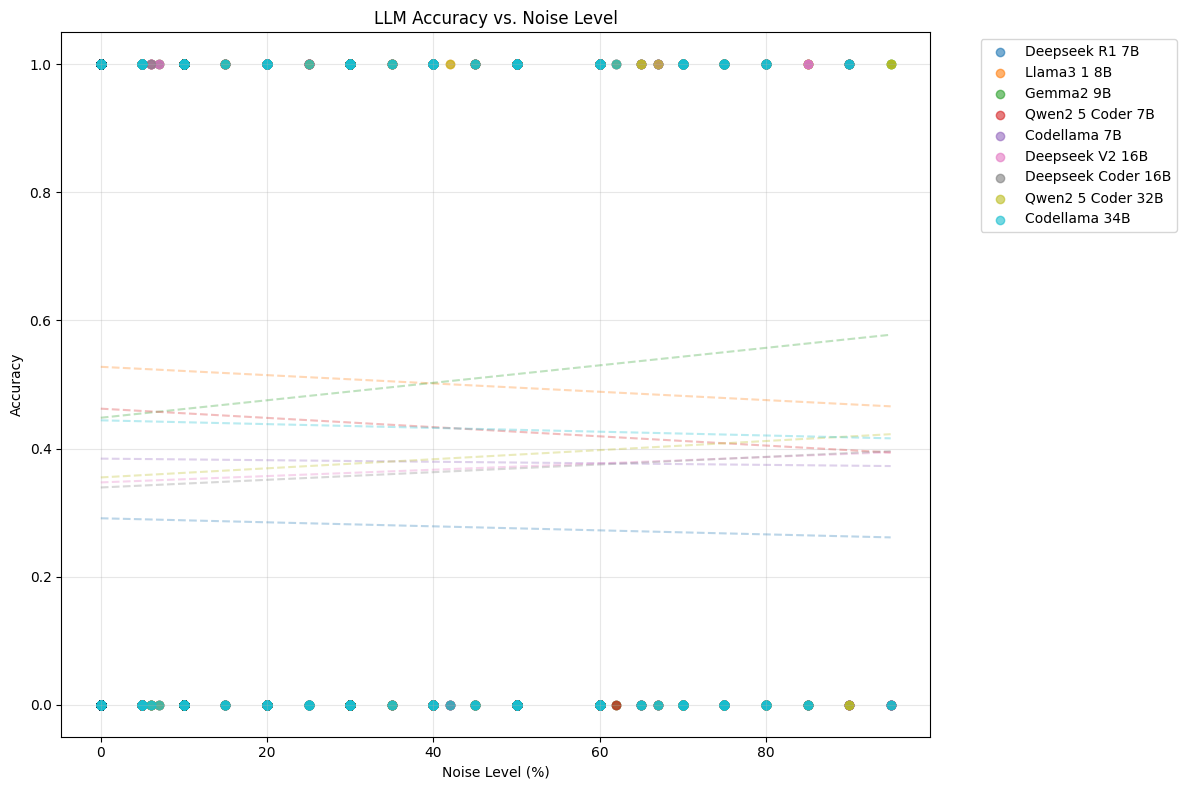

In [3]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import os

def calculate_accuracy(df, column_name):
    # Filter out rows where ground truth is 2 (ambiguous)
    valid_rows = df[df['ground_truth'] != 2]
    
    # Calculate accuracy
    correct = (
        ((valid_rows['ground_truth'] == 1) & (valid_rows[column_name] == 1)) | 
        ((valid_rows['ground_truth'] == 0) & (valid_rows[column_name] == 0))
    ).sum()
    
    accuracy = correct / len(valid_rows) if len(valid_rows) > 0 else 0
    ambiguous_count = len(df[df['ground_truth'] == 2])
    
    return accuracy, ambiguous_count

def calculate_counts(df, column_name):
    """Calculate counts of 0, 1, and 2 in a column"""
    if column_name not in df.columns:
        return None
    counts = df[column_name].value_counts().to_dict()
    return {
        '0': counts.get(0, 0),
        '1': counts.get(1, 0),
        '2': counts.get(2, 0)
    }

def calculate_model_accuracy(df, column_name, total_samples=594):
    """Calculate accuracy based on total samples"""
    if column_name not in df.columns:
        return None, None
        
    counts = df[column_name].value_counts().to_dict()
    ones = counts.get(1, 0)
    zeros = counts.get(0, 0)
    twos = counts.get(2, 0)
    
    # For Vuln, we want accuracy of 1s (ground truth is 1)
    # For Patch, we want accuracy of 0s (ground truth is 0)
    if 'VULN' in column_name.upper():
        accuracy = (ones / total_samples) * 100
    else:  # PATCH
        accuracy = (zeros / total_samples) * 100
        
    return accuracy, f"{ones} {{1}} {zeros} {{0}} {twos} {{2}}"

def main():
    # Connect to database with correct path
    db_path = '/users/azibaeir/Research/Benchmarking/project/vulnerability_dataset/database/database.sqlite'
    
    if not os.path.exists(db_path):
        print(f"Database file not found at {db_path}")
        return None
        
    conn = sqlite3.connect(db_path)
    
    # Get list of tables in the database
    cursor = conn.cursor()
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
    tables = cursor.fetchall()
    print(f"Tables in database: {[table[0] for table in tables]}")
    
    # First, get the schema of the vulnerabilities table to see available columns
    cursor.execute("PRAGMA table_info(vulnerabilities)")
    vuln_columns = cursor.fetchall()
    print(f"Vulnerabilities table columns: {[col[1] for col in vuln_columns]}")
    
    # Load the vulnerabilities table with available columns
    vulnerabilities = pd.read_sql('SELECT * FROM vulnerabilities', conn)
    print(f"Loaded {len(vulnerabilities)} vulnerability records")
    
    # Check if noise_level column exists, if not, use a default or create it
    if 'noise_level' not in vulnerabilities.columns:
        print("No noise_level column found in vulnerabilities table")
        # Check if there's any column that might contain noise information
        noise_candidates = [col for col in vulnerabilities.columns if 'noise' in col.lower()]
        if noise_candidates:
            print(f"Found potential noise columns: {noise_candidates}")
            vulnerabilities['noise_level'] = vulnerabilities[noise_candidates[0]]
        else:
            print("Creating synthetic noise_level for demonstration")
            # Create a synthetic noise level for demonstration purposes
            np.random.seed(42)  # For reproducibility
            vulnerabilities['noise_level'] = np.random.uniform(0, 100, size=len(vulnerabilities))
    
    # Get a list of model-specific tables
    model_tables = [table[0] for table in tables if table[0].startswith('vulnerabilities_')]
    print(f"Found model tables: {model_tables}")
    
    # Create a combined dataframe for all models
    all_models_data = []
    
    for table_name in model_tables:
        # Extract model name from table name
        model_name = table_name.replace('vulnerabilities_', '').replace('_', ' ').title()
        
        # Get schema for this table
        cursor.execute(f"PRAGMA table_info({table_name})")
        table_columns = cursor.fetchall()
        print(f"{table_name} columns: {[col[1] for col in table_columns]}")
        
        # Load data from this table
        try:
            model_data = pd.read_sql(f'SELECT * FROM {table_name}', conn)
            print(f"Loaded {len(model_data)} records from {table_name}")
            
            # Add model name column
            model_data['model'] = model_name
            
            # Standardize column names if needed
            if 'COMMIT_HASH' in model_data.columns and 'commit_hash' not in model_data.columns:
                model_data['commit_hash'] = model_data['COMMIT_HASH']
            
            # Add to combined data
            all_models_data.append(model_data)
        except Exception as e:
            print(f"Error loading data from {table_name}: {e}")
    
    # Combine all model data
    if all_models_data:
        decisions = pd.concat(all_models_data, ignore_index=True)
        print(f"Combined {len(decisions)} records from all model tables")
    else:
        print("No model data could be loaded")
        return None
    
    # Ensure we have the necessary columns
    required_columns = ['commit_hash', 'ground_truth']
    prompt_columns = [
        'BASELINE_VULN', 'BASELINE_PATCH',
        'COT_VULN', 'COT_PATCH',
        'THINK_VULN', 'THINK_PATCH',
        'THINK_VERIFY_VULN', 'THINK_VERIFY_PATCH'
    ]
    
    # Check if columns exist, if not, try to find alternatives
    for col in required_columns:
        if col not in decisions.columns:
            print(f"Missing required column: {col}")
            # Try to find alternative column names
            if col == 'commit_hash':
                alternatives = ['COMMIT_HASH', 'hash', 'commit']
                for alt in alternatives:
                    if alt in decisions.columns:
                        decisions['commit_hash'] = decisions[alt]
                        break
            elif col == 'ground_truth':
                # If ground_truth is missing, we might need to create it
                if 'is_vulnerable' in decisions.columns:
                    decisions['ground_truth'] = decisions['is_vulnerable']
                else:
                    # Try to determine ground truth from table structure or column names
                    vuln_indicators = [col for col in decisions.columns if 'vuln' in col.lower() and not any(p in col.lower() for p in ['baseline', 'cot', 'think', 'verify'])]
                    
                    if vuln_indicators:
                        print(f"Using {vuln_indicators[0]} to determine ground truth")
                        decisions['ground_truth'] = decisions[vuln_indicators[0]]
                    else:
                        # Default assumption: create synthetic ground truth for demonstration
                        print("Creating synthetic ground_truth for demonstration")
                        decisions['ground_truth'] = np.random.choice([0, 1], size=len(decisions))
    
    # Merge decisions with vulnerabilities to get noise levels and other metadata
    print(f"Decisions columns: {decisions.columns.tolist()}")
    print(f"Vulnerabilities columns: {vulnerabilities.columns.tolist()}")
    
    # Ensure commit_hash is lowercase in both dataframes for consistent joining
    if 'commit_hash' in decisions.columns:
        decisions['commit_hash'] = decisions['commit_hash'].str.lower()
    elif 'COMMIT_HASH' in decisions.columns:
        decisions['commit_hash'] = decisions['COMMIT_HASH'].str.lower()
    
    if 'commit_hash' in vulnerabilities.columns:
        vulnerabilities['commit_hash'] = vulnerabilities['commit_hash'].str.lower()
    elif 'COMMIT_HASH' in vulnerabilities.columns:
        vulnerabilities['commit_hash'] = vulnerabilities['COMMIT_HASH'].str.lower()
        vulnerabilities['commit_hash'] = vulnerabilities['COMMIT_HASH'].str.lower()
    
    # Merge on commit_hash
    df = pd.merge(decisions, vulnerabilities, on='commit_hash', how='left')
    print(f"After merging, dataframe has {len(df)} rows and columns: {df.columns.tolist()}")
    
    # If noise_level is missing after merge, try alternative column names
    if 'noise_level' not in df.columns:
        noise_alternatives = ['NOISE_LEVEL', 'noise', 'noise_score']
        for alt in noise_alternatives:
            if alt in df.columns:
                df['noise_level'] = df[alt]
                break
        else:
            print("No noise level column found after merge, creating synthetic data")
            df['noise_level'] = np.random.uniform(0, 100, size=len(df))
    
    # Calculate accuracies for each model and prompt type
    results = {}
    models = df['model'].unique().tolist()
    print(f"Models found: {models}")
    
    prompts = {
        'Baseline': ['BASELINE_VULN', 'BASELINE_PATCH'],
        'CoT': ['COT_VULN', 'COT_PATCH'],
        'Think': ['THINK_VULN', 'THINK_PATCH'],
        'Think-Verify': ['THINK_VERIFY_VULN', 'THINK_VERIFY_PATCH']
    }
    
    # Calculate accuracies and store results
    for model in models:
        model_df = df[df['model'] == model]
        results[model] = {}
        
        for prompt_name, columns in prompts.items():
            # Check if columns exist
            if columns[0] in model_df.columns and columns[1] in model_df.columns:
                vuln_acc, vuln_amb = calculate_accuracy(model_df, columns[0])
                patch_acc, patch_amb = calculate_accuracy(model_df, columns[1])
                
                results[model][prompt_name] = {
                    'vuln_acc': vuln_acc * 100,  # Convert to percentage
                    'patch_acc': patch_acc * 100,  # Convert to percentage
                    'vuln_amb': vuln_amb,
                    'patch_amb': patch_amb
                }
            else:
                print(f"Columns {columns} not found for model {model}")
    
    # Calculate counts for each model and prompt type
    for model in models:
        model_df = df[df['model'] == model]
        print(f"\n=== {model} ===")
        
        for prompt_name, columns in prompts.items():
            print(f"\n{prompt_name}:")
            
            # Vulnerability counts
            vuln_counts = calculate_counts(model_df, columns[0])
            if vuln_counts:
                print(f"Vuln: {vuln_counts['1']} {{1}} {vuln_counts['0']} {{0}} {vuln_counts['2']} {{2}}")
            
            # Patch counts
            patch_counts = calculate_counts(model_df, columns[1])
            if patch_counts:
                print(f"Patch: {patch_counts['1']} {{1}} {patch_counts['0']} {{0}} {patch_counts['2']} {{2}}")
    
    # Create scatter plot for noise vs accuracy
    plt.figure(figsize=(12, 8))
    colors = plt.cm.tab10(np.linspace(0, 1, len(models)))
    
    for model, color in zip(models, colors):
        model_df = df[df['model'] == model]
        
        # Check if noise_level column exists
        if 'noise_level' not in model_df.columns:
            print(f"No noise_level data for model {model}")
            continue
            
        accuracies = []
        noise_levels = []
        
        # Use Think-Verify strategy for noise analysis if available
        if 'THINK_VERIFY_VULN' in model_df.columns:
            target_col = 'THINK_VERIFY_VULN'
        elif 'THINK_VULN' in model_df.columns:
            target_col = 'THINK_VULN'
        elif 'COT_VULN' in model_df.columns:
            target_col = 'COT_VULN'
        elif 'BASELINE_VULN' in model_df.columns:
            target_col = 'BASELINE_VULN'
        else:
            print(f"No suitable accuracy column found for model {model}")
            continue
        
        for _, row in model_df.iterrows():
            if pd.notna(row['ground_truth']) and row['ground_truth'] != 2 and pd.notna(row[target_col]) and pd.notna(row['noise_level']):
                accuracy = 1 if (
                    (row['ground_truth'] == 1 and row[target_col] == 1) or
                    (row['ground_truth'] == 0 and row[target_col] == 0)
                ) else 0
                accuracies.append(accuracy)
                noise_levels.append(row['noise_level'])
        
        if accuracies and noise_levels:  # Only plot if we have data
            plt.scatter(noise_levels, accuracies, label=model, alpha=0.6, c=[color])
            
            # Calculate and plot trend line
            z = np.polyfit(noise_levels, accuracies, 1)
            p = np.poly1d(z)
            plt.plot(sorted(noise_levels), p(sorted(noise_levels)), '--', color=color, alpha=0.3)
            
            # Calculate correlation
            correlation, p_value = stats.pearsonr(noise_levels, accuracies)
            print(f"{model} - Correlation: {correlation:.3f}, p-value: {p_value:.3f}")
    
    plt.xlabel('Noise Level (%)')
    plt.ylabel('Accuracy')
    plt.title('LLM Accuracy vs. Noise Level')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('noise_vs_accuracy.png', dpi=300, bbox_inches='tight')
    
    # Find example of a buffer overflow vulnerability (CWE-119) that was misclassified
    # Look for CVE information in the vulnerabilities table
    if 'CVE' in vulnerabilities.columns or 'cve_id' in vulnerabilities.columns:
        cve_col = 'CVE' if 'CVE' in vulnerabilities.columns else 'cve_id'
        project_col = next((col for col in vulnerabilities.columns if 'project' in col.lower()), None)
        
        # Find a buffer overflow example
        buffer_overflow_examples = vulnerabilities[
            vulnerabilities['VULNERABILITY_CWE'].str.contains('CWE-119', na=False) if 'VULNERABILITY_CWE' in vulnerabilities.columns 
            else vulnerabilities['cwe_id'].str.contains('CWE-119', na=False)
        ]
        
        if not buffer_overflow_examples.empty:
            example = buffer_overflow_examples.iloc[0]
            cve_id = example[cve_col] if cve_col in example else "Unknown"
            project = example[project_col] if project_col and project_col in example else "Unknown"
            commit_hash = example['commit_hash'] if 'commit_hash' in example else example['COMMIT_HASH'] if 'COMMIT_HASH' in example else "Unknown"
            
            print(f"\nExample Buffer Overflow (CWE-119):")
            print(f"CVE ID: {cve_id}")
            print(f"Project: {project}")
            print(f"Commit Hash: {commit_hash}")
        else:
            print("\nNo buffer overflow examples found in the dataset")
    
    # Print formatted results
    print("\nAccuracy Results:")
    print("=" * 80)
    for model in models:
        print(f"\n{model}:")
        for prompt, metrics in results[model].items():
            print(f"\n{prompt}:")
            print(f"  Vulnerability Detection Accuracy: {metrics['vuln_acc']:.2f}%")
            print(f"  Patch Detection Accuracy: {metrics['patch_acc']:.2f}%")
            print(f"  Ambiguous Cases (Vuln): {metrics['vuln_amb']}")
            print(f"  Ambiguous Cases (Patch): {metrics['patch_amb']}")
    
    # Create a table for the paper
    table_data = []
    for model in models:
        model_row = [model]
        for prompt_name in prompts:
            if prompt_name in results[model]:
                model_row.append(f"{results[model][prompt_name]['vuln_acc']:.1f}")
                model_row.append(f"{results[model][prompt_name]['patch_acc']:.1f}")
            else:
                model_row.append("-")
                model_row.append("-")
        table_data.append(model_row)
    
    # Create a DataFrame for the table
    columns = ['Model']
    for prompt in prompts:
        columns.extend([f"{prompt} (Vuln)", f"{prompt} (Patch)"])
    
    table_df = pd.DataFrame(table_data, columns=columns)
    print("\nTable for Paper:")
    print(table_df.to_string(index=False))
    
    # Save table to CSV for easy copy-paste
    table_df.to_csv('results_table.csv', index=False)
    
    # Define models and their context sizes
    model_info = {
        'Deepseek-v2': '131K',
        'Llama3.1': '131K',
        'Gemma2': '8K',
        'Deepseek-coder-v2': '163K',
        'Qwen2.5-coder': '32K',
        'Codellama': '16K',
        'Deepseek-R1': '131K'
    }
    
    # After loading data and before plotting
    print("\nModel Accuracies:")
    latex_rows = []
    
    for model_name, context_size in model_info.items():
        model_df = df[df['model'] == model_name]
        row_data = [f"{model_name} ({context_size})"]
        
        print(f"\n=== {model_name} ===")
        
        for prompt_type in ['BASELINE', 'COT', 'THINK', 'THINK_VERIFY']:
            vuln_col = f"{prompt_type}_VULN"
            patch_col = f"{prompt_type}_PATCH"
            
            vuln_acc, vuln_counts = calculate_model_accuracy(model_df, vuln_col)
            patch_acc, patch_counts = calculate_model_accuracy(model_df, patch_col)
            
            if vuln_acc is not None:
                print(f"\n{prompt_type}:")
                print(f"Vuln: {vuln_counts}")
                print(f"Vuln Accuracy: {vuln_acc:.2f}%")
                print(f"Patch: {patch_counts}")
                print(f"Patch Accuracy: {patch_acc:.2f}%")
                
                row_data.extend([f"{vuln_acc:.2f}", f"{patch_acc:.2f}"])
            else:
                row_data.extend(["-", "-"])
        
        # Add row to LaTeX table
        latex_row = f"{model_name} & \\textit{{{context_size}}} & " + \
                   " & ".join(row_data[1:]) + " \\\\"
        latex_rows.append(latex_row)
    
    # Print LaTeX table
    print("\nLaTeX Table Content:")
    print("\n".join(latex_rows))
    
    return results

if __name__ == '__main__':
    results = main()

# RQ1.2 NOISE VS ACCURACY

In [7]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.nonparametric.smoothers_lowess import lowess

# ------------------------------------------------------------
# 1. Connect to the database
# ------------------------------------------------------------
db_path = '/users/azibaeir/Research/Benchmarking/project/vulnerability_dataset/database/database.sqlite'
conn = sqlite3.connect(db_path)

# ------------------------------------------------------------
# 2. Read Noise info (commit -> noise amount)
# ------------------------------------------------------------
vuln_df = pd.read_sql_query(
    """
    SELECT COMMIT_HASH, NOISE_AMOUNT
    FROM vulnerabilities
    WHERE NOISE_AMOUNT IS NOT NULL
    """,
    conn
)

# ------------------------------------------------------------
# 3. List of model tables
# ------------------------------------------------------------
model_tables = [
    'vulnerabilities_deepseek_r1_7b',
    'vulnerabilities_llama3_1_8b',
    'vulnerabilities_gemma2_9b',
    'vulnerabilities_qwen2_5_coder_7b',
    'vulnerabilities_codellama_7b',
    'vulnerabilities_deepseek_r1_32b',
    'vulnerabilities_deepseek_v2_16b',
    'vulnerabilities_deepseek_coder_16b',
    'vulnerabilities_qwen2_5_coder_32b',
    'vulnerabilities_codellama_34b'
]

# ------------------------------------------------------------
# 4. Define columns for each prompt type
# ------------------------------------------------------------
vuln_cols  = ['BASELINE_VULN',  'COT_VULN',  'THINK_VULN',  'THINK_VERIFY_VULN']
patch_cols = ['BASELINE_PATCH', 'COT_PATCH', 'THINK_PATCH', 'THINK_VERIFY_PATCH']

# ------------------------------------------------------------
# 5. Convert "2" -> 0.5, keep "0" or "1" as is
# ------------------------------------------------------------
def map_ambiguous_to_half(x):
    try:
        val = float(x)
        if val == 2:
            return 0.5
        return val
    except:
        return np.nan

all_models_list = []

# ------------------------------------------------------------
# 6. Read each model's data, compute overall vuln/patch accuracy
# ------------------------------------------------------------
for table_name in model_tables:
    query = f"""
        SELECT 
            COMMIT_HASH,
            BASELINE_VULN, BASELINE_PATCH,
            COT_VULN, COT_PATCH,
            THINK_VULN, THINK_PATCH,
            THINK_VERIFY_VULN, THINK_VERIFY_PATCH
        FROM {table_name}
        WHERE BASELINE_VULN IS NOT NULL
          AND COT_VULN IS NOT NULL
          AND THINK_VULN IS NOT NULL
          AND THINK_VERIFY_VULN IS NOT NULL
    """
    try:
        model_df = pd.read_sql_query(query, conn)
        if len(model_df) == 0:
            print(f"[WARNING] No valid data in {table_name}")
            continue
        
        # Convert columns to numeric, handle "2" -> 0.5
        for col in vuln_cols + patch_cols:
            model_df[col] = pd.to_numeric(model_df[col], errors='coerce').apply(map_ambiguous_to_half)
        
        # Mean accuracy across all prompts
        model_df['vuln_accuracy']  = model_df[vuln_cols].mean(axis=1)  * 100.0
        model_df['patch_accuracy'] = model_df[patch_cols].mean(axis=1) * 100.0
        
        # Merge with noise amounts
        merged = pd.merge(model_df, vuln_df, on='COMMIT_HASH', how='inner')
        if len(merged) == 0:
            print(f"[WARNING] After merge, no data for {table_name}")
            continue
        
        # Clean model name
        model_name = table_name.replace('vulnerabilities_', '').replace('_', ' ').title()
        merged['model_name'] = model_name
        
        merged = merged[['COMMIT_HASH','model_name','vuln_accuracy','patch_accuracy','NOISE_AMOUNT']]
        all_models_list.append(merged)
        
    except Exception as e:
        print(f"[ERROR] {table_name}: {e}")

conn.close()

# ------------------------------------------------------------
# 7. Combine all data and drop missing
# ------------------------------------------------------------
if not all_models_list:
    print("No valid data found across any table.")
    exit()

final_df = pd.concat(all_models_list, ignore_index=True).dropna()
if len(final_df) == 0:
    print("No valid rows remain after dropping NAs.")
    exit()

# ------------------------------------------------------------
# 8. Bin the noise amounts in 20% increments
#    0–20, 20–40, 40–60, 60–80, 80–100
# ------------------------------------------------------------
bins = [0, 20, 40, 60, 80, 100]
labels = ["0-20", "20-40", "40-60", "60-80", "80-100"]

final_df['noise_bin'] = pd.cut(
    final_df['NOISE_AMOUNT'], 
    bins=bins, 
    labels=labels, 
    include_lowest=True,
    right=False
)

# ------------------------------------------------------------
# 9. Group by (model_name, noise_bin) and compute mean accuracies
# ------------------------------------------------------------
df_vuln_binned = (
    final_df.groupby(['model_name','noise_bin'])['vuln_accuracy']
    .mean()
    .reset_index()
)
df_patch_binned = (
    final_df.groupby(['model_name','noise_bin'])['patch_accuracy']
    .mean()
    .reset_index()
)

# ------------------------------------------------------------
# 10. Convert noise_bin to numeric bin centers for plotting
# ------------------------------------------------------------
def bin_label_to_center(label: str) -> float:
    # e.g. "0-20" => midpoint is 10
    left_str, right_str = label.split('-')
    return (float(left_str) + float(right_str)) / 2.0

df_vuln_binned['bin_center']  = df_vuln_binned['noise_bin'].astype(str).apply(bin_label_to_center)
df_patch_binned['bin_center'] = df_patch_binned['noise_bin'].astype(str).apply(bin_label_to_center)

# ------------------------------------------------------------
# 11. Plot: Vulnerability Accuracy vs Noise
#     Binned at 20%, Y-axis ticks every 10%
# ------------------------------------------------------------
plt.figure(figsize=(10,6))
ax1 = plt.gca()

unique_models = df_vuln_binned['model_name'].unique()

for model_name in unique_models:
    model_data = df_vuln_binned[df_vuln_binned['model_name'] == model_name].dropna()
    if len(model_data) < 1:
        continue
    
    model_data = model_data.sort_values(by='bin_center')
    
    # Scatter points
    ax1.scatter(
        model_data['bin_center'], 
        model_data['vuln_accuracy'],
        label=model_name,
        alpha=0.7
    )
    
    # LOWESS smoothing if >= 3 points
    if len(model_data) >= 3:
        smoothed = lowess(
            endog=model_data['vuln_accuracy'],
            exog=model_data['bin_center'],
            frac=0.5
        )
        ax1.plot(smoothed[:,0], smoothed[:,1])
    else:
        ax1.plot(model_data['bin_center'], model_data['vuln_accuracy'])

# Set X-axis tick marks at the midpoints
ax1.set_xticks([10, 30, 50, 70, 90])
ax1.set_xticklabels(labels)

# Set Y-axis ticks every 10%
ax1.set_yticks(np.arange(0, 101, 10))
ax1.set_ylim(0, 105)

ax1.set_xlabel("Noise Bins (%)")
ax1.set_ylabel("Vulnerability Accuracy (%)")
ax1.set_title("Vulnerability Detection vs. Noise (20% bins, 10% y‐ticks)")
ax1.grid(alpha=0.3)
ax1.legend(loc='best', title='Model')

plt.tight_layout()
plt.savefig('vulnerability_vs_noise_20pct_bins.png', dpi=300)
plt.close()

# ------------------------------------------------------------
# 12. Plot: Patch Accuracy vs Noise
#     Binned at 20%, Y-axis ticks every 10%
# ------------------------------------------------------------
plt.figure(figsize=(10,6))
ax2 = plt.gca()

for model_name in unique_models:
    model_data = df_patch_binned[df_patch_binned['model_name'] == model_name].dropna()
    if len(model_data) < 1:
        continue
    
    model_data = model_data.sort_values(by='bin_center')
    
    ax2.scatter(
        model_data['bin_center'], 
        model_data['patch_accuracy'],
        label=model_name,
        alpha=0.7
    )
    
    # LOWESS smoothing if >= 3 points
    if len(model_data) >= 3:
        smoothed = lowess(
            endog=model_data['patch_accuracy'],
            exog=model_data['bin_center'],
            frac=0.5
        )
        ax2.plot(smoothed[:,0], smoothed[:,1])
    else:
        ax2.plot(model_data['bin_center'], model_data['patch_accuracy'])

ax2.set_xticks([10, 30, 50, 70, 90])
ax2.set_xticklabels(labels)

ax2.set_yticks(np.arange(0, 101, 10))
ax2.set_ylim(0, 105)

ax2.set_xlabel("Noise Bins (%)")
ax2.set_ylabel("Patch Correctness Accuracy (%)")
ax2.set_title("Patch Correctness vs. Noise (20% bins, 10% y‐ticks)")
ax2.grid(alpha=0.3)
ax2.legend(loc='best', title='Model')

plt.tight_layout()
plt.savefig('patch_vs_noise_20pct_bins.png', dpi=300)
plt.close()

print("Done! Two figures saved:\n"
      " - vulnerability_vs_noise_20pct_bins.png\n"
      " - patch_vs_noise_20pct_bins.png\n")


[WARNING] No valid data in vulnerabilities_deepseek_r1_32b


/tmp/ipykernel_880852/4014216340.py:141: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  final_df.groupby(['model_name','noise_bin'])['vuln_accuracy']
/tmp/ipykernel_880852/4014216340.py:146: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  final_df.groupby(['model_name','noise_bin'])['patch_accuracy']


Done! Two figures saved:
 - vulnerability_vs_noise_20pct_bins.png
 - patch_vs_noise_20pct_bins.png



In [8]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from statsmodels.nonparametric.smoothers_lowess import lowess

# ----------------------------------------------------------------
# 1. Connect to the database
# ----------------------------------------------------------------
db_path = '/users/azibaeir/Research/Benchmarking/project/vulnerability_dataset/database/database.sqlite'
conn = sqlite3.connect(db_path)

# ----------------------------------------------------------------
# 2. Load Noise info (commit -> noise amount)
# ----------------------------------------------------------------
vuln_df = pd.read_sql_query(
    """
    SELECT COMMIT_HASH, NOISE_AMOUNT
    FROM vulnerabilities
    WHERE NOISE_AMOUNT IS NOT NULL
    """,
    conn
)

# ----------------------------------------------------------------
# 3. Model tables
# ----------------------------------------------------------------
model_tables = [
    'vulnerabilities_deepseek_r1_7b',
    'vulnerabilities_llama3_1_8b',
    'vulnerabilities_gemma2_9b',
    'vulnerabilities_qwen2_5_coder_7b',
    'vulnerabilities_codellama_7b',
    'vulnerabilities_deepseek_r1_32b',
    'vulnerabilities_deepseek_v2_16b',
    'vulnerabilities_deepseek_coder_16b',
    'vulnerabilities_qwen2_5_coder_32b',
    'vulnerabilities_codellama_34b'
]

# ----------------------------------------------------------------
# 4. Prompt columns (separated)
# ----------------------------------------------------------------
# We'll treat them individually instead of averaging:
vuln_prompts = {
    'Baseline':      'BASELINE_VULN',
    'CoT':           'COT_VULN',
    'Think':         'THINK_VULN',
    'Think+Verify':  'THINK_VERIFY_VULN'
}
patch_prompts = {
    'Baseline':      'BASELINE_PATCH',
    'CoT':           'COT_PATCH',
    'Think':         'THINK_PATCH',
    'Think+Verify':  'THINK_VERIFY_PATCH'
}

# ----------------------------------------------------------------
# 5. Convert "2" -> 0.5
# ----------------------------------------------------------------
def map_ambiguous_to_half(x):
    try:
        val = float(x)
        if val == 2:
            return 0.5
        return val
    except:
        return np.nan

all_models_list = []

# ----------------------------------------------------------------
# 6. Read each model's data (with all prompts)
# ----------------------------------------------------------------
for table_name in model_tables:
    query = f"""
        SELECT
            COMMIT_HASH,
            BASELINE_VULN,  BASELINE_PATCH,
            COT_VULN,       COT_PATCH,
            THINK_VULN,     THINK_PATCH,
            THINK_VERIFY_VULN, THINK_VERIFY_PATCH
        FROM {table_name}
        WHERE BASELINE_VULN IS NOT NULL
          AND COT_VULN      IS NOT NULL
          AND THINK_VULN    IS NOT NULL
          AND THINK_VERIFY_VULN IS NOT NULL
    """
    try:
        model_df = pd.read_sql_query(query, conn)
        if model_df.empty:
            print(f"[WARNING] No valid data in {table_name}")
            continue
        
        # Convert columns to numeric, handle "2" -> 0.5
        for col in vuln_prompts.values():
            model_df[col] = pd.to_numeric(model_df[col], errors='coerce').apply(map_ambiguous_to_half)
        for col in patch_prompts.values():
            model_df[col] = pd.to_numeric(model_df[col], errors='coerce').apply(map_ambiguous_to_half)
        
        # Merge with noise
        merged = pd.merge(model_df, vuln_df, on='COMMIT_HASH', how='inner')
        if merged.empty:
            print(f"[WARNING] After merge, no data for {table_name}")
            continue
        
        # Clean name
        model_name = table_name.replace('vulnerabilities_', '').replace('_', ' ').title()
        merged['model_name'] = model_name
        
        all_models_list.append(merged)
        
    except Exception as e:
        print(f"[ERROR] {table_name} => {e}")

conn.close()

# ----------------------------------------------------------------
# 7. Combine everything, drop missing
# ----------------------------------------------------------------
if not all_models_list:
    print("No valid data across all tables.")
    exit()

final_df = pd.concat(all_models_list, ignore_index=True).dropna(subset=['NOISE_AMOUNT'])
if final_df.empty:
    print("No valid rows remain after dropping NAs.")
    exit()

# ----------------------------------------------------------------
# 8. Bin the noise in 20% increments (0–20, 20–40, ...)
# ----------------------------------------------------------------
bins = [0,20,40,60,80,100]
labels = ["0-20","20-40","40-60","60-80","80-100"]

final_df['noise_bin'] = pd.cut(
    final_df['NOISE_AMOUNT'],
    bins=bins,
    labels=labels,
    include_lowest=True,
    right=False
)

# ----------------------------------------------------------------
# 9. For each model, plot each prompt separately
#    We'll produce 1 figure per model, with 2 subplots:
#    (A) Vulnerability lines (Baseline, CoT, Think, Think+Verify)
#    (B) Patch lines (Baseline, CoT, Think, Think+Verify)
# ----------------------------------------------------------------
unique_models = final_df['model_name'].unique()

# Helper to get bin center for plotting
def bin_label_to_center(label: str) -> float:
    left, right = label.split('-')
    return (float(left) + float(right))/2.0

for model_name in unique_models:
    model_data = final_df[final_df['model_name'] == model_name].copy()
    if model_data.empty:
        continue
    
    # We'll create data for each prompt / bin => {mean, std}
    # store in a dict like: results_vuln[prompt] = df with columns [bin_center, mean, std]
    
    results_vuln = {}
    results_patch = {}
    
    for prompt_label, prompt_col in vuln_prompts.items():
        # group by the noise_bin and compute mean & std
        group_stats = (
            model_data.groupby('noise_bin')[prompt_col]
            .agg(['mean','std'])
            .reset_index()
        )
        group_stats['bin_center'] = group_stats['noise_bin'].astype(str).apply(bin_label_to_center)
        results_vuln[prompt_label] = group_stats
    
    for prompt_label, prompt_col in patch_prompts.items():
        group_stats = (
            model_data.groupby('noise_bin')[prompt_col]
            .agg(['mean','std'])
            .reset_index()
        )
        group_stats['bin_center'] = group_stats['noise_bin'].astype(str).apply(bin_label_to_center)
        results_patch[prompt_label] = group_stats
    
    # ----------------------------------------------------------------
    # Make 2 subplots side-by-side:
    # left = vulnerability prompts, right = patch prompts
    # Each prompt => line + shaded region (±1 std)
    # ----------------------------------------------------------------
    fig, (ax_left, ax_right) = plt.subplots(1, 2, figsize=(12,5))
    fig.suptitle(f"{model_name} - Per-Prompt Accuracy vs. Noise Bins (20%)", fontsize=14)
    
    # ---------- Left: Vulnerability ----------
    for prompt_label, df_prompt in results_vuln.items():
        # sort by bin_center to avoid zig-zag
        df_prompt = df_prompt.dropna(subset=['bin_center','mean']).sort_values('bin_center')
        
        x = df_prompt['bin_center']
        y = df_prompt['mean'] * 100.0  # convert to percentage if needed
        s = df_prompt['std']  * 100.0
        
        # line
        ax_left.plot(x, y, label=prompt_label)
        # fill ±1 std
        ax_left.fill_between(x, y - s, y + s, alpha=0.2)
    
    ax_left.set_xticks([10, 30, 50, 70, 90])
    ax_left.set_xticklabels(labels)
    ax_left.set_yticks(np.arange(0,101,10))
    ax_left.set_ylim([0,105])
    ax_left.set_title("Vulnerability Accuracy")
    ax_left.set_xlabel("Noise Bins (%)")
    ax_left.set_ylabel("Accuracy (%)")
    ax_left.grid(alpha=0.3)
    ax_left.legend(title="Prompt")
    
    # ---------- Right: Patch ----------
    for prompt_label, df_prompt in results_patch.items():
        df_prompt = df_prompt.dropna(subset=['bin_center','mean']).sort_values('bin_center')
        
        x = df_prompt['bin_center']
        y = df_prompt['mean'] * 100.0
        s = df_prompt['std']  * 100.0
        
        ax_right.plot(x, y, label=prompt_label)
        ax_right.fill_between(x, y - s, y + s, alpha=0.2)
    
    ax_right.set_xticks([10, 30, 50, 70, 90])
    ax_right.set_xticklabels(labels)
    ax_right.set_yticks(np.arange(0,101,10))
    ax_right.set_ylim([0,105])
    ax_right.set_title("Patch Accuracy")
    ax_right.set_xlabel("Noise Bins (%)")
    ax_right.grid(alpha=0.3)
    ax_right.legend(title="Prompt")
    
    plt.tight_layout()
    # Save figure named by the model
    fig.savefig(f"{model_name}_prompts_accuracy_vs_noise.png", dpi=300)
    plt.close(fig)

print("Done! Generated one PNG per model, each showing four lines (Baseline, CoT, Think, Think+Verify).")


[WARNING] No valid data in vulnerabilities_deepseek_r1_32b


/tmp/ipykernel_880852/3224747708.py:172: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  model_data.groupby('noise_bin')[prompt_col]
/tmp/ipykernel_880852/3224747708.py:172: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  model_data.groupby('noise_bin')[prompt_col]
/tmp/ipykernel_880852/3224747708.py:172: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  model_data.groupby('noise_bin')[prompt_col]
/tmp/ipykernel_880852/322474770

Done! Generated one PNG per model, each showing four lines (Baseline, CoT, Think, Think+Verify).


In [10]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------------------------------------------
# 1. Connect to DB and read noise
# ----------------------------------------------------------------
db_path = '/users/azibaeir/Research/Benchmarking/project/vulnerability_dataset/database/database.sqlite'
conn = sqlite3.connect(db_path)

vuln_df = pd.read_sql_query(
    """
    SELECT COMMIT_HASH, NOISE_AMOUNT
    FROM vulnerabilities
    WHERE NOISE_AMOUNT IS NOT NULL
    """,
    conn
)

model_tables = [
    'vulnerabilities_deepseek_r1_7b',
    'vulnerabilities_llama3_1_8b',
    'vulnerabilities_gemma2_9b',
    'vulnerabilities_qwen2_5_coder_7b',
    'vulnerabilities_codellama_7b',
    'vulnerabilities_deepseek_r1_32b',
    'vulnerabilities_deepseek_v2_16b',
    'vulnerabilities_deepseek_coder_16b',
    'vulnerabilities_qwen2_5_coder_32b',
    'vulnerabilities_codellama_34b'
]

vuln_prompts = {
    'Baseline':      'BASELINE_VULN',
    'CoT':           'COT_VULN',
    'Think':         'THINK_VULN',
    'Think+Verify':  'THINK_VERIFY_VULN'
}
patch_prompts = {
    'Baseline':      'BASELINE_PATCH',
    'CoT':           'COT_PATCH',
    'Think':         'THINK_PATCH',
    'Think+Verify':  'THINK_VERIFY_PATCH'
}

def map_ambiguous_to_half(x):
    """Convert '2' → 0.5, else keep 0 or 1."""
    try:
        val = float(x)
        return 0.5 if val == 2 else val
    except:
        return np.nan

all_models = []

# ----------------------------------------------------------------
# 2. Read each model’s data, combine vuln+patch
# ----------------------------------------------------------------
for table_name in model_tables:
    query = f"""
        SELECT 
            COMMIT_HASH,
            BASELINE_VULN, BASELINE_PATCH,
            COT_VULN, COT_PATCH,
            THINK_VULN, THINK_PATCH,
            THINK_VERIFY_VULN, THINK_VERIFY_PATCH
        FROM {table_name}
        WHERE BASELINE_VULN IS NOT NULL
          AND COT_VULN IS NOT NULL
          AND THINK_VULN IS NOT NULL
          AND THINK_VERIFY_VULN IS NOT NULL
    """
    try:
        df = pd.read_sql_query(query, conn)
        if df.empty:
            continue
        
        # Convert "2" → 0.5
        for col in list(vuln_prompts.values()) + list(patch_prompts.values()):
            df[col] = pd.to_numeric(df[col], errors='coerce').apply(map_ambiguous_to_half)
        
        # Merge with noise
        merged = pd.merge(df, vuln_df, on='COMMIT_HASH', how='inner')
        if merged.empty:
            continue
        
        # Clean up model name
        model_name = table_name.replace('vulnerabilities_', '').replace('_', ' ').title()
        merged['model_name'] = model_name
        
        all_models.append(merged)
    except Exception as e:
        print(f"[ERROR] {table_name}: {e}")

conn.close()

if not all_models:
    print("No valid data across all tables.")
    exit()

final_df = pd.concat(all_models, ignore_index=True).dropna(subset=['NOISE_AMOUNT'])
if final_df.empty:
    print("No rows remain after dropping missing NOISE_AMOUNT.")
    exit()

# ----------------------------------------------------------------
# 3. Compute combined accuracy per prompt = (vuln + patch) / 2
#    Then reshape to "long" form (model, commit, noise, prompt, combined_accuracy)
# ----------------------------------------------------------------
final_df['BASELINE_COMBINED']       = (final_df['BASELINE_VULN'] + final_df['BASELINE_PATCH']) / 2
final_df['COT_COMBINED']            = (final_df['COT_VULN']      + final_df['COT_PATCH'])      / 2
final_df['THINK_COMBINED']          = (final_df['THINK_VULN']    + final_df['THINK_PATCH'])    / 2
final_df['THINK_VERIFY_COMBINED']   = (final_df['THINK_VERIFY_VULN'] + final_df['THINK_VERIFY_PATCH']) / 2

prompt_map = {
    'Baseline':      'BASELINE_COMBINED',
    'CoT':           'COT_COMBINED',
    'Think':         'THINK_COMBINED',
    'Think+Verify':  'THINK_VERIFY_COMBINED'
}

long_list = []
for prompt_label, col in prompt_map.items():
    subset = final_df[['model_name','COMMIT_HASH','NOISE_AMOUNT', col]].copy()
    subset.rename(columns={col:'combined_accuracy'}, inplace=True)
    subset['prompt'] = prompt_label
    long_list.append(subset)

final_long_df = pd.concat(long_list, ignore_index=True).dropna(subset=['combined_accuracy'])

# ----------------------------------------------------------------
# 4. Bin noise (0–10, 10–20, …, 90–100) for smoother lines
# ----------------------------------------------------------------
bins = np.arange(0, 101, 10)  # 0..10..20..100
labels = [f"{b}-{b+10}" for b in bins[:-1]]  # "0-10","10-20",...

final_long_df['noise_bin'] = pd.cut(
    final_long_df['NOISE_AMOUNT'],
    bins=bins,
    labels=labels,
    right=False,
    include_lowest=True
)

# group by (model, prompt, noise_bin) => compute mean & std
grouped = final_long_df.groupby(['model_name','prompt','noise_bin'])
df_stats = grouped['combined_accuracy'].agg(['mean','std','count']).reset_index()

# We'll plot x as bin center: e.g. "0-10" => 5, "10-20" => 15, etc.
def bin_label_to_center(label):
    left, right = label.split('-')
    return (float(left) + float(right)) / 2.

df_stats['bin_center'] = df_stats['noise_bin'].astype(str).apply(bin_label_to_center)

# ----------------------------------------------------------------
# 5. Plot: 2×5 subplots, 1 per model, 4 lines (prompts)
# ----------------------------------------------------------------
import math
import matplotlib.pyplot as plt

unique_models = df_stats['model_name'].unique()
n_models = len(unique_models)

nrows = 2
ncols = 5
fig, axes = plt.subplots(nrows, ncols, figsize=(25, 10), sharey=True)
axes = axes.ravel()

prompts_order = ['Baseline','CoT','Think','Think+Verify']
colors = {
    'Baseline':      'blue',
    'CoT':           'orange',
    'Think':         'green',
    'Think+Verify':  'red'
}

for i, model_name in enumerate(unique_models):
    ax = axes[i]
    
    for prompt_label in prompts_order:
        sub = df_stats[(df_stats['model_name'] == model_name) &
                       (df_stats['prompt'] == prompt_label)]
        if sub.empty:
            continue
        
        x = sub['bin_center']
        y = sub['mean']
        e = sub['std']
        
        # Plot line
        ax.plot(
            x, y, 
            label=prompt_label, 
            color=colors.get(prompt_label, None),
            lw=2
        )
        # ±1 std shading
        ax.fill_between(
            x, 
            y - e, 
            y + e,
            color=colors.get(prompt_label, None), 
            alpha=0.2
        )
    
    ax.set_title(model_name, fontsize=12)
    ax.set_xlabel("Noise Bin Center (%)")
    ax.set_ylabel("Combined Accuracy\n(Vuln & Patch)")
    ax.set_ylim(0, 1.05)
    ax.set_xticks([5,15,25,35,45,55,65,75,85,95])
    ax.set_xticklabels(labels, rotation=45)
    ax.grid(alpha=0.3)

# Turn off any extra unused subplots if < 10
if n_models < nrows*ncols:
    for j in range(n_models, nrows*ncols):
        fig.delaxes(axes[j])

# Single legend at top
handles, labels_ = axes[0].get_legend_handles_labels()
fig.legend(
    handles, labels_, 
    loc='upper center', 
    bbox_to_anchor=(0.5, 1.05),
    ncol=4,
    title="Prompt"
)

plt.tight_layout(rect=[0,0,1,0.98])
plt.suptitle("Per-Model Combined Accuracy vs. Binned Noise (4 Prompts)\nMean ± 1 std Over 10% Noise Bins", fontsize=16)
plt.savefig("all_llms_combined_accuracy_prompts_binned.png", dpi=300)
plt.close(fig)

print("Done! Created a single figure with 10 subplots, each showing 4 lines. Lines are smoother due to 10% noise binning.")


/tmp/ipykernel_880852/2176689094.py:147: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = final_long_df.groupby(['model_name','prompt','noise_bin'])


Done! Created a single figure with 10 subplots, each showing 4 lines. Lines are smoother due to 10% noise binning.
